# Yelp dataset classification

The yelp dataset contains the comments with ratings, so our task is: **given a comment, judge the rating**. Since the rating can only be 1-5, the task is **text classification**.

So our model's input is: the user's comment and should output the logits or probabilities of each class, for example:

input: `the service is good`

output: `[0.1,0.1,0.1,0.1,0.6]` indicating a hight probabiliy of score 5.

## 0. Prepare the data

Loda the data from `yelp` folder. star_X indicates the score (i.e., the class).

What we do:
- load the dataset from file (using hugginface's dataset library)
- print the statistics of the dataset
- train test split (with fixed seed)

In [1]:
from datasets import Dataset, DatasetDict
import os 
# Disable NCCL for RTX 40 Series GPUs.
os.environ["NCCL_P2P_DISABLE"]="1"
os.environ["NCCL_IB_DISABLE"]="1"
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors,Word2Vec
from transformers import BertTokenizer, BertModel
from transformers import AutoModelForSequenceClassification,TrainingArguments,Trainer
import torch
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
def load_yelp_dataset(base_path):
    data = {"text": [], "star": []}
    
    # Iterate through each star folder
    for star in range(1, 6):
        star_folder = os.path.join(base_path, f"star_{star}")
        if not os.path.exists(star_folder):
            continue
        
        # Read all review files in the star folder
        for file_name in os.listdir(star_folder):
            if file_name.endswith(".txt"):
                file_path = os.path.join(star_folder, file_name)
                with open(file_path, "r", encoding="utf-8") as f:
                    text = f.read().strip()
                    data["text"].append(text)
                    data["star"].append(star-1)  # Convert 1-5 to 0-4
    
    # Convert to Hugging Face Dataset
    dataset = Dataset.from_dict(data)
    return dataset

In [3]:
dataset = load_yelp_dataset("./yelp")

In [4]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=1)

# Convert to DatasetDict for consistency
split_dataset = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

# Print the split dataset
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'star'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'star'],
        num_rows: 300
    })
})


In [5]:
# Print dataset information
print("Dataset Information:")
print(split_dataset)

# Print number of samples in each split
print("\nNumber of Samples:")
for split in split_dataset.keys():
    print(f"{split}: {len(split_dataset[split])}")

# Print class distribution
print("\nClass Distribution:")
star_distribution = split_dataset["train"].to_pandas()["star"].value_counts().sort_index()
print(star_distribution)

Dataset Information:
DatasetDict({
    train: Dataset({
        features: ['text', 'star'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'star'],
        num_rows: 300
    })
})

Number of Samples:
train: 1200
test: 300

Class Distribution:
star
0    209
1    192
2    401
3    192
4    206
Name: count, dtype: int64


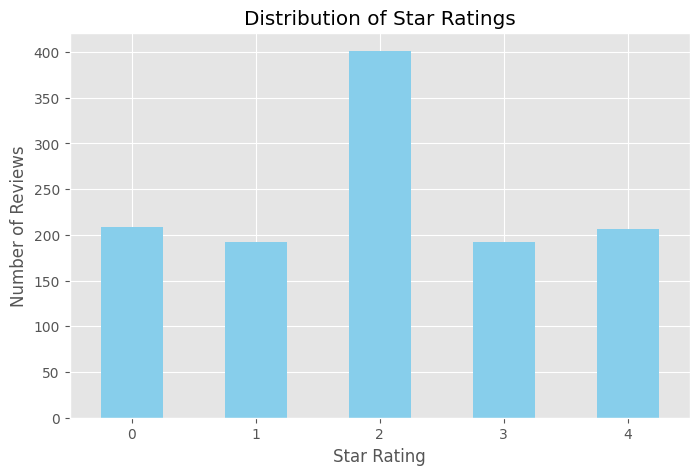

In [6]:
# Plot class distribution
plt.figure(figsize=(8, 5))
star_distribution.plot(kind="bar", color="skyblue")
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

In [7]:
# Print a few sample reviews
print("\nSample Reviews:")
for i in range(3):  # Print 3 samples
    print(f"Star: {split_dataset['train'][i]['star']}")
    print(f"Text: {split_dataset['train'][i]['text']}")
    print("-" * 50)


Sample Reviews:
Star: 1
Text: I drove by because I happened to be hungry, and it was there. When I walked in , it reminded me a lot of Panda Express, except, I'd rather had eaten at Panda. The place was clean and quite, but I think I may have gone on a not so good day. I had the orange chicken, and it was a little chewy and rubbery as if it had been sitting under that lamp for too long. The egg roll had a weird taste, then again, when I went, I was pretty much given the scraps that were left. IF, I decide to go back, hopefully it will be better.
--------------------------------------------------
Star: 4
Text: Great experience.
Super punctual and accommodating.
Far less than half the price of dealership to replace my car key and cheaper than the other locksmiths I looked up as well.  
5 stars all the way
--------------------------------------------------
Star: 2
Text: I understand the need to cater to North American customers, but the yakitori here tastes too "clean". Nowhere near smok

## 1. Build a baseline model

- Use a `LogisticRegression` model
- Use `TfidfVectorizer` to convert text data to numerical representations
- Finally got `0.4467` acc and `0.48`,`0.42`,`0.39` precision, racall, f1 respectively. Below are the detailed performance:

```bash
              precision    recall  f1-score   support

           1       0.59      0.66      0.62        41
           2       0.45      0.09      0.14        58
           3       0.40      0.75      0.52        99
           4       0.44      0.12      0.19        58
           5       0.51      0.48      0.49        44

    accuracy                           0.45       300
   macro avg       0.48      0.42      0.39       300
weighted avg       0.46      0.45      0.39       300
```

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of a model on the test set.

    Args:
        model: Trained machine learning model.
        X_test: Test features (e.g., TF-IDF vectors).
        y_test: True labels for the test set.

    Returns:
        None (prints metrics and plots confusion matrix).
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
    
    # Fit and transform the training data
    X_train = vectorizer.fit_transform(split_dataset["train"]["text"])
    
    # Transform the test data
    X_test = vectorizer.transform(split_dataset["test"]["text"])
    
    # Get the labels
    y_train = split_dataset["train"]["star"]
    y_test = split_dataset["test"]["star"]

In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Accuracy: 0.4667

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57        41
           1       0.40      0.07      0.12        58
           2       0.45      0.81      0.58        99
           3       0.54      0.12      0.20        58
           4       0.45      0.55      0.49        44

    accuracy                           0.47       300
   macro avg       0.48      0.43      0.39       300
weighted avg       0.47      0.47      0.40       300


Confusion Matrix:


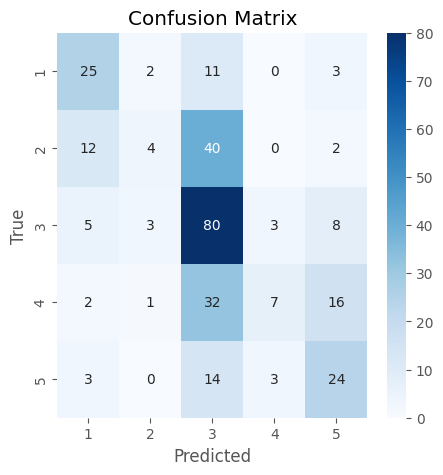

In [11]:
evaluate_model(model, X_test, y_test)

## 2&3. Compare with different data analytics model/word embedding model and perform hyper-parameter tuning with the models.

Here we plan to use these techniques:
- ​**Classic Models**:
  - Naive Bayes
  - Decision Tree
  - XGBoost
- ​**Deep Learning Models**:
  - BERT (Encoder Only LLM, needs fine-tuning)
- ​**Word Embedding Methods**:
  - BERT (Extract sentence embeddings for classification)
  - GloVE
  - Word2vec
  - TF-IDF
- ​**Hyper-parameter Search**:
  - Type: Randomized Search
  - Searching Criterion: Accuracy

Hyperparameters for Each Model

### Logistic Regression
- ​**Model**: `LogisticRegression(max_iter=1000, random_state=42)`
- ​**Hyperparameters**:
  - `penalty`: ["l1", "l2", "elasticnet"]
  - `C`: [0.1, 1.0, 10.0]
  - `solver`: ["saga"] (works with all penalties)
  - `class_weight`: [None, "balanced"]
  - `l1_ratio`: [0.3, 0.5, 0.7] (only used with elasticnet)

### Naive Bayes
- ​**Model**: `MultinomialNB()`
- ​**Hyperparameters**:
  - `alpha`: [0.1, 0.5, 1.0, 2.0]
  - `fit_prior`: [True, False]

### Decision Tree
- ​**Model**: `DecisionTreeClassifier(random_state=42)`
- ​**Hyperparameters**:
  - `criterion`: ["gini", "entropy"]
  - `max_depth`: [None, 10, 20, 30]
  - `min_samples_split`: [2, 5, 10]
  - `min_samples_leaf`: [1, 2, 4]
  - `max_features`: ["sqrt", "log2", None]

### XGBoost
- ​**Model**: `XGBClassifier(random_state=42)`
- ​**Hyperparameters**:
  - `n_estimators`: [50, 100, 200]
  - `learning_rate`: [0.01, 0.1, 0.2]
  - `max_depth`: [3, 5, 7]
  - `subsample`: [0.6, 0.8, 1.0]
  - `colsample_bytree`: [0.6, 0.8, 1.0]
  - `gamma`: [0, 0.1, 0.2]
  - `reg_alpha`: [0, 0.1, 0.5]
  - `reg_lambda`: [0, 0.1, 0.5]

### Best Results

After Hyper-parameter tuning, we got 56.67% best accuracy with BERT embedding and BERT model.

In [12]:
# Prepare embeddings
def tfidf_embedding(train_text, test_text, max_features=5000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train = vectorizer.fit_transform(train_text)
    X_test = vectorizer.transform(test_text)
    return X_train, X_test
def glove_embedding(train_text, test_text, embedding_dim=100):
    # Load pre-trained GloVe embeddings (download from https://nlp.stanford.edu/projects/glove/)
    glove_file = "glove.6B.100d.txt"
    word2vec_file = "glove.6B.100d.word2vec.txt"
    glove2word2vec(glove_file, word2vec_file)
    model = KeyedVectors.load_word2vec_format(word2vec_file)
    
    # Convert text to embeddings (average of word vectors)
    def text_to_avg_vector(texts):
        vectors = []
        for text in texts:
            words = text.split()
            vec = np.mean([model[word] for word in words if word in model], axis=0)
            vectors.append(vec)
        return np.array(vectors)
    
    X_train = text_to_avg_vector(train_text)
    X_test = text_to_avg_vector(test_text)
    return X_train, X_test

def word2vec_embedding(train_text, test_text, embedding_dim=100):
    # Train Word2Vec on your corpus (or load pre-trained)
    sentences = [text.split() for text in train_text + test_text]
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    
    # Convert text to embeddings (average of word vectors)
    def text_to_avg_vector(texts):
        vectors = []
        for text in texts:
            words = text.split()
            vec = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
            vectors.append(vec)
        return np.array(vectors)
    
    X_train = text_to_avg_vector(train_text)
    X_test = text_to_avg_vector(test_text)
    return X_train, X_test

def bert_embedding(train_text, test_text, max_length=128):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",cache_dir="./")
    model = BertModel.from_pretrained("bert-base-uncased",cache_dir="./")
    
    def text_to_embeddings(texts):
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()
    
    X_train = text_to_embeddings(train_text)
    X_test = text_to_embeddings(test_text)
    return X_train, X_test

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = {
    # Logistic Regression with extended hyperparameters
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "penalty": ["l1", "l2", "elasticnet"],
            "C": [0.1, 1.0, 10.0],
            "solver": ["saga"],  # Works with all penalties
            "class_weight": [None, "balanced"],
            "l1_ratio": [0.3, 0.5, 0.7]  # Only used with elasticnet
        }
    },
    
    # Naive Bayes with extended hyperparameters
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {
            "alpha": [0.1, 0.5, 1.0, 2.0],
            "fit_prior": [True, False]
        }
    },
    
    # Decision Tree with extended hyperparameters
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", None]
        }
    },
    
    # XGBoost with extended hyperparameters
    "XGBoost": {
        "model": XGBClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "gamma": [0, 0.1, 0.2],
            "reg_alpha": [0, 0.1, 0.5],
            "reg_lambda": [0, 0.1, 0.5]
        }
    }
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(model, params, X_train, y_train):
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=200,
        cv=3,
        scoring="accuracy",
        n_jobs=80,  # Use all CPU cores
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")
    return grid.best_estimator_


Training Logistic Regression with TF-IDF embeddings...
Current feature shape: (1200, 5000)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only

Best parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.3, 'class_weight': None, 'C': 10.0}
Accuracy: 0.4467

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.56      0.48        41
           1       0.31      0.16      0.21        58
           2       0.47      0.64      0.54        99
           3       0.45      0.24      0.31        58
           4       0.50      0.57      0.53        44

    accuracy                           0.45       300
   macro avg       0.43      0.43      0.41       300
weighted avg       0.43      0.45      0.42       300


Confusion Matrix:


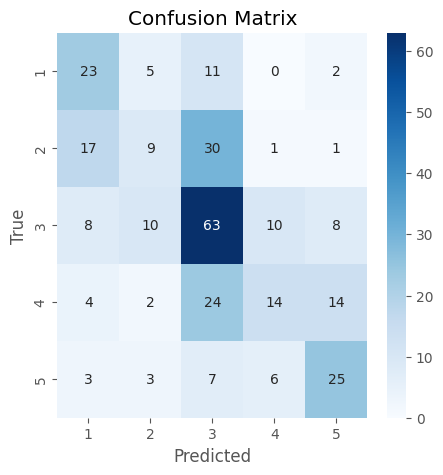


Training Naive Bayes with TF-IDF embeddings...
Current feature shape: (1200, 5000)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'fit_prior': True, 'alpha': 0.1}
Accuracy: 0.4467

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        41
           1       0.40      0.03      0.06        58
           2       0.40      0.88      0.55        99
           3       0.50      0.09      0.15        58
           4       0.70      0.43      0.54        44

    accuracy                           0.45       300
   macro avg       0.50      0.39      0.36       300
weighted avg       0.48      0.45      0.37       300


Confusion Matrix:


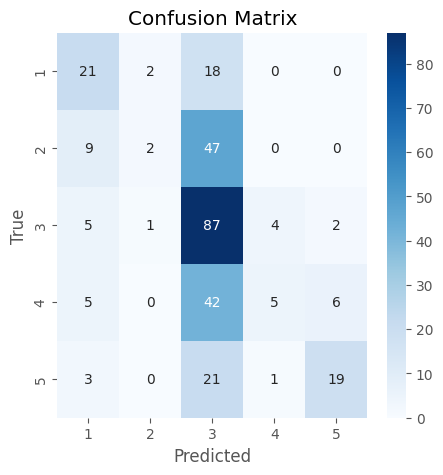


Training Decision Tree with TF-IDF embeddings...
Current feature shape: (1200, 5000)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}
Accuracy: 0.3367

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.10      0.13        41
           1       0.27      0.07      0.11        58
           2       0.37      0.85      0.52        99
           3       0.00      0.00      0.00        58
           4       0.24      0.20      0.22        44

    accuracy                           0.34       300
   macro avg       0.22      0.24      0.20       300
weighted avg       0.24      0.34      0.24       300


Confusion Matrix:


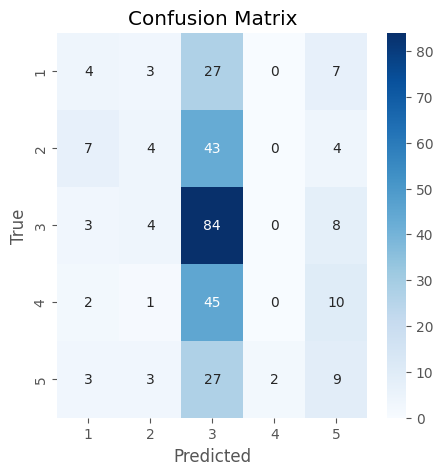


Training XGBoost with TF-IDF embeddings...
Current feature shape: (1200, 5000)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.4567

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.63      0.59        41
           1       0.30      0.14      0.19        58
           2       0.46      0.71      0.56        99
           3       0.37      0.19      0.25        58
           4       0.51      0.50      0.51        44

    accuracy                           0.46       300
   macro avg       0.44      0.43      0.42       300
weighted avg       0.43      0.46      0.42       300


Confusion Matrix:


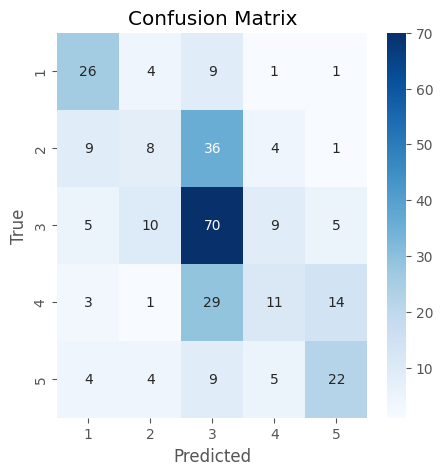


Training Logistic Regression with GloVe embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only

Best parameters: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.3, 'class_weight': None, 'C': 1.0}
Accuracy: 0.4233

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46        41
           1       0.33      0.05      0.09        58
           2       0.43      0.72      0.53        99
           3       0.55      0.10      0.17        58
           4       0.48      0.50      0.49        44

    accuracy                           0.42       300
   macro avg       0.43      0.40      0.35       300
weighted avg       0.43      0.42      0.36       300


Confusion Matrix:


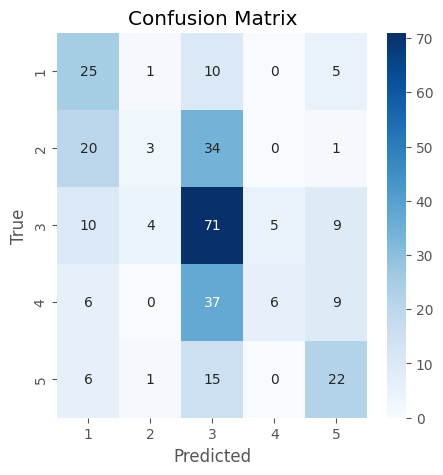


Training Naive Bayes with GloVe embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Error tuning Naive Bayes: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 759, in fit
    self._count(X, Y)

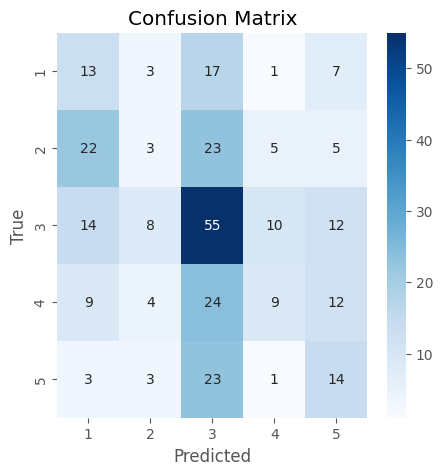


Training XGBoost with GloVe embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.3967

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.54      0.44        41
           1       0.33      0.12      0.18        58
           2       0.39      0.61      0.48        99
           3       0.36      0.16      0.22        58
           4       0.48      0.48      0.48        44

    accuracy                           0.40       300
   macro avg       0.39      0.38      0.36       300
weighted avg       0.39      0.40      0.36       300


Confusion Matrix:


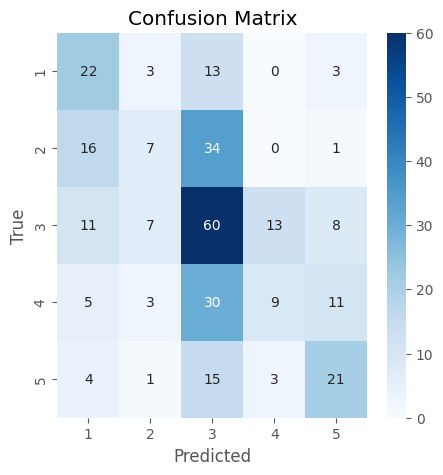


Training Logistic Regression with Word2Vec embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only

Best parameters: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.3, 'class_weight': None, 'C': 10.0}
Accuracy: 0.3500

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.49      0.43        41
           1       0.00      0.00      0.00        58
           2       0.36      0.79      0.49        99
           3       0.00      0.00      0.00        58
           4       0.23      0.16      0.19        44

    accuracy                           0.35       300
   macro avg       0.20      0.29      0.22       300
weighted avg       0.21      0.35      0.25       300


Confusion Matrix:


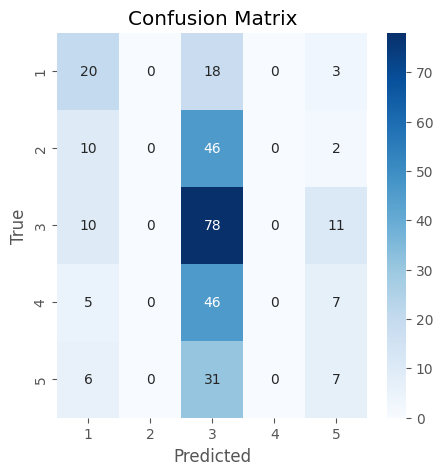


Training Naive Bayes with Word2Vec embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Error tuning Naive Bayes: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 759, in fit
    self._count(X,

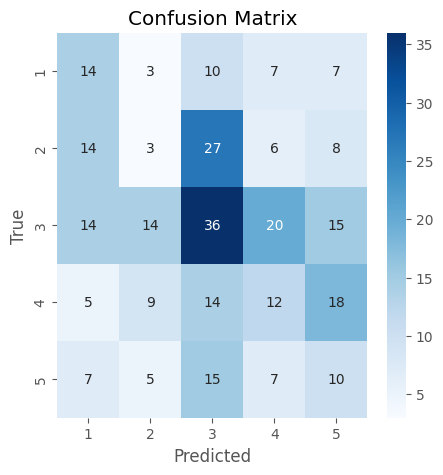


Training XGBoost with Word2Vec embeddings...
Current feature shape: (1200, 100)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Accuracy: 0.3667

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.49      0.40        41
           1       0.44      0.07      0.12        58
           2       0.37      0.81      0.51        99
           3       0.67      0.03      0.07        58
           4       0.36      0.09      0.15        44

    accuracy                           0.37       300
   macro avg       0.44      0.30      0.25       300
weighted avg       0.44      0.37      0.28       300


Confusion Matrix:


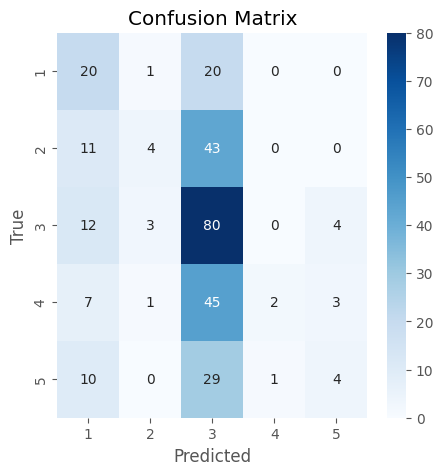


Training Logistic Regression with BERT embeddings...
Current feature shape: (1200, 768)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only

Best parameters: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.3, 'class_weight': None, 'C': 0.1}
Accuracy: 0.4833

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.80      0.62        41
           1       0.40      0.14      0.21        58
           2       0.47      0.68      0.56        99
           3       0.50      0.16      0.24        58
           4       0.51      0.64      0.57        44

    accuracy                           0.48       300
   macro avg       0.48      0.48      0.44       300
weighted avg       0.47      0.48      0.44       300


Confusion Matrix:


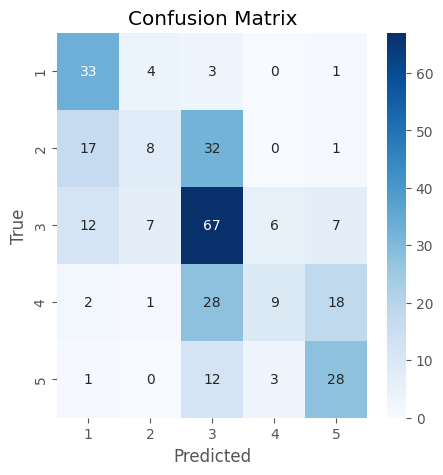


Training Naive Bayes with BERT embeddings...
Current feature shape: (1200, 768)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Error tuning Naive Bayes: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 759, in fit
    self._count(X, Y)


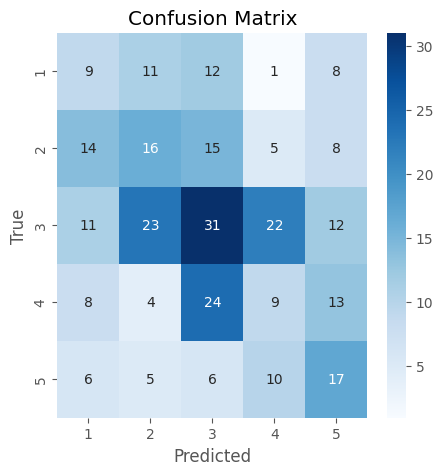


Training XGBoost with BERT embeddings...
Current feature shape: (1200, 768)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.4733

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.76      0.63        41
           1       0.42      0.17      0.24        58
           2       0.49      0.71      0.58        99
           3       0.23      0.09      0.12        58
           4       0.49      0.59      0.54        44

    accuracy                           0.47       300
   macro avg       0.43      0.46      0.42       300
weighted avg       0.43      0.47      0.43       300


Confusion Matrix:


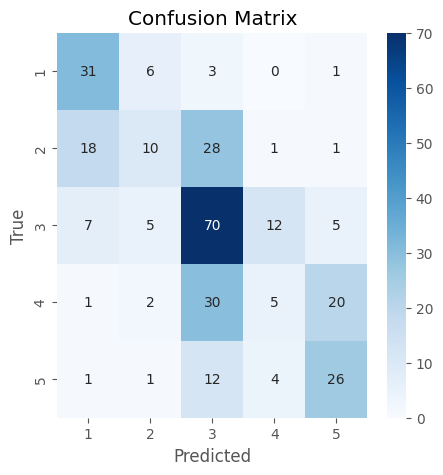


Final Results:


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize results storage
results = []
# Load dataset
train_text = split_dataset["train"]["text"]
train_labels = split_dataset["train"]["star"]
test_text = split_dataset["test"]["text"]
test_labels = split_dataset["test"]["star"]

# Define embeddings to test
embeddings = {
    "TF-IDF": tfidf_embedding,
    "GloVe": glove_embedding,
    "Word2Vec": word2vec_embedding,
    "BERT": bert_embedding
}
# Iterate through embeddings
for emb_name, emb_func in embeddings.items():
    # Generate embeddings
    X_train, X_test = emb_func(train_text, test_text)
    
    # Iterate through models
    for model_name, model_config in models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name} with {emb_name} embeddings...")
        print(f"Current feature shape: {X_train.shape}")
        
        # Hyperparameter tuning
        try:
            best_model = tune_model(
                model_config["model"], 
                model_config["params"], 
                X_train, 
                train_labels
            )
        except Exception as e:
            print(f"Error tuning {model_name}: {e}")
            results.append({
            "Embedding": emb_name,
            "Model": model_name,
            "Accuracy": 0,
            "Best Params": None
            })
            continue
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(test_labels, y_pred)
        evaluate_model(best_model,X_test,test_labels)
        # Save results
        results.append({
            "Embedding": emb_name,
            "Model": model_name,
            "Accuracy": accuracy,
            "Best Params": best_model.get_params()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Results:")
# results_df.sort_values(by="Accuracy", ascending=False)

In [16]:
results_df.sort_values(by="Accuracy", ascending=False)

Embedding                Model  Accuracy  \
12      BERT  Logistic Regression  0.483333   
15      BERT              XGBoost  0.473333   
3     TF-IDF              XGBoost  0.456667   
0     TF-IDF  Logistic Regression  0.446667   
1     TF-IDF          Naive Bayes  0.446667   
4      GloVe  Logistic Regression  0.423333   
7      GloVe              XGBoost  0.396667   
11  Word2Vec              XGBoost  0.366667   
8   Word2Vec  Logistic Regression  0.350000   
2     TF-IDF        Decision Tree  0.336667   
6      GloVe        Decision Tree  0.313333   
14      BERT        Decision Tree  0.273333   
10  Word2Vec        Decision Tree  0.250000   
5      GloVe          Naive Bayes  0.000000   
9   Word2Vec          Naive Bayes  0.000000   
13      BERT          Naive Bayes  0.000000   

                                          Best Params  
12  {'C': 0.1, 'class_weight': None, 'dual': False...  
15  {'objective': 'multi:softprob', 'base_score': ...  
3   {'objective': 'multi:softprob', 'base_score': ...  
0   {'C': 10.0, 'class_weight': None, 'dual': Fals...  
1   {'alpha': 0.1, 'class_prior': None, 'fit_prior...  
4   {'C': 1.0, 'class_weight': None, 'dual': False...  
7   {'objective': 'multi:softprob', 'base_score': ...  
11  {'objective': 'multi:softprob', 'base_score': ...  
8   {'C': 10.0, 'class_weight': None, 'dual': Fals...  
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
6   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
14  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
10  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
5                                                None  
9                                                None  
13                                               None

Training BERT, the logic is different with sklearn-like models.

In [17]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name,cache_dir="./")

def tokenize_and_prepare_dataset(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    tokenized_inputs["labels"] = examples["star"]  # Add labels to the tokenized inputs
    return tokenized_inputs

# Tokenize the entire dataset
tokenized_dataset = split_dataset.map(tokenize_and_prepare_dataset, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,  # 5 classes for star ratings (1-5)
    cache_dir="./"
)
training_args = TrainingArguments(
    output_dir="./bert_results", # Output directory (required even if not saving)
    eval_strategy="steps",       # Evaluate every `eval_steps`
    eval_steps=50,               # Evaluate every 50 steps
    logging_strategy="steps",    # Log every `logging_steps`
    logging_steps=10,            # Log every 10 steps
    save_strategy="no",          # Disable model saving
    report_to="none",            # Disable reporting (e.g., no WandB, TensorBoard, etc.)
    learning_rate=2e-5,          # Default: 2e-5 to 5e-5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    max_steps=300,               # Train for 200 steps
    weight_decay=0.01,           # Regularization
    logging_dir="./logs",        # Directory for logs
    load_best_model_at_end=False,# Disable loading the best model at the end
    seed=42
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print(classification_report(labels,predictions))
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2025-04-01 12:19:42,436] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ubuntu/miniconda3/envs/pytorch/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.6
 [WARNING]  using untested triton version (3.2.0), only 1.0.0 is known to be compatible


              precision    recall  f1-score   support

           0       0.47      0.66      0.55        41
           1       1.00      0.02      0.03        58
           2       0.45      0.81      0.58        99
           3       0.00      0.00      0.00        58
           4       0.53      0.73      0.62        44

    accuracy                           0.47       300
   macro avg       0.49      0.44      0.35       300
weighted avg       0.48      0.47      0.36       300

              precision    recall  f1-score   support

           0       0.47      0.85      0.61        41
           1       0.50      0.10      0.17        58
           2       0.57      0.68      0.62        99
           3       0.51      0.34      0.41        58
           4       0.59      0.77      0.67        44

    accuracy                           0.54       300
   macro avg       0.53      0.55      0.50       300
weighted avg       0.54      0.54      0.50       300

              precisio

TrainOutput(global_step=300, training_loss=0.835057414372762, metrics={'train_runtime': 73.1159, 'train_samples_per_second': 131.298, 'train_steps_per_second': 4.103, 'total_flos': 624116233924608.0, 'train_loss': 0.835057414372762, 'epoch': 7.894736842105263})

In [18]:
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        41
           1       0.51      0.33      0.40        58
           2       0.56      0.70      0.62        99
           3       0.46      0.31      0.37        58
           4       0.62      0.75      0.68        44

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.55      0.56      0.55       300

Test Accuracy: 0.5633


In [19]:
# Add the new entry
new_entry = pd.DataFrame({
    "Embedding": ["BERT"],
    "Model": ["BERT"],
    "Accuracy": [results['eval_accuracy']],
    "Best Params": [None]
})

results_df = pd.concat([results_df, new_entry], ignore_index=True)
results_df

Embedding                Model  Accuracy  \
0     TF-IDF  Logistic Regression  0.446667   
1     TF-IDF          Naive Bayes  0.446667   
2     TF-IDF        Decision Tree  0.336667   
3     TF-IDF              XGBoost  0.456667   
4      GloVe  Logistic Regression  0.423333   
5      GloVe          Naive Bayes  0.000000   
6      GloVe        Decision Tree  0.313333   
7      GloVe              XGBoost  0.396667   
8   Word2Vec  Logistic Regression  0.350000   
9   Word2Vec          Naive Bayes  0.000000   
10  Word2Vec        Decision Tree  0.250000   
11  Word2Vec              XGBoost  0.366667   
12      BERT  Logistic Regression  0.483333   
13      BERT          Naive Bayes  0.000000   
14      BERT        Decision Tree  0.273333   
15      BERT              XGBoost  0.473333   
16      BERT                 BERT  0.563333   

                                          Best Params  
0   {'C': 10.0, 'class_weight': None, 'dual': Fals...  
1   {'alpha': 0.1, 'class_prior': None, 'fit_prior...  
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
3   {'objective': 'multi:softprob', 'base_score': ...  
4   {'C': 1.0, 'class_weight': None, 'dual': False...  
5                                                None  
6   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
7   {'objective': 'multi:softprob', 'base_score': ...  
8   {'C': 10.0, 'class_weight': None, 'dual': Fals...  
9                                                None  
10  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
11  {'objective': 'multi:softprob', 'base_score': ...  
12  {'C': 0.1, 'class_weight': None, 'dual': False...  
13                                               None  
14  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
15  {'objective': 'multi:softprob', 'base_score': ...  
16                                               None

## 4. Visualize with a range of different data statistics methods

### 1. ​**Star Rating Distribution (Train vs Test)**  
   - Comparative bar chart to visualize star rating distribution in train and test sets.

### 2. ​**Text Length Analysis**  
   - Box plot to analyze text length distribution by star rating.

### 3. ​**Word Cloud for Each Star Rating**  
   - Word clouds to visualize frequent words for each star rating.

### 4. ​**Top N Words Analysis**  
   - Bar plot to display the top 20 most frequent words in the dataset.

### 5. ​**Statistical Metrics Table**  
   - Table summarizing statistical metrics (mean, median, std, min, max) for star ratings.

### 6. ​**Text Length Statistics**  
   - Heatmap to visualize text length statistics (mean, median, std, min, max) by star rating.

### Additional Statistical Analysis  
   - Numerical insights: central tendency, dispersion metrics, and class balance analysis.


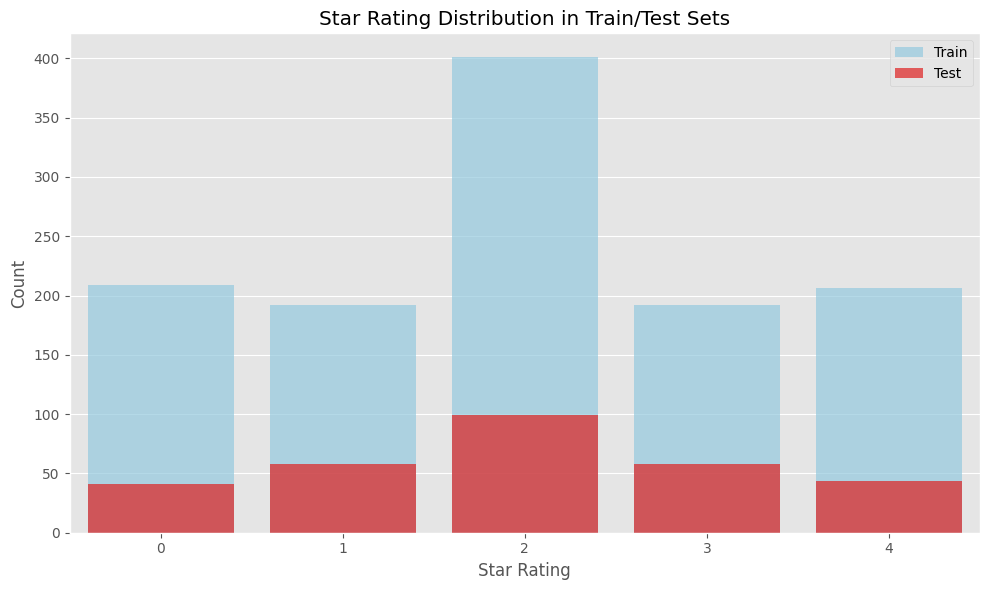

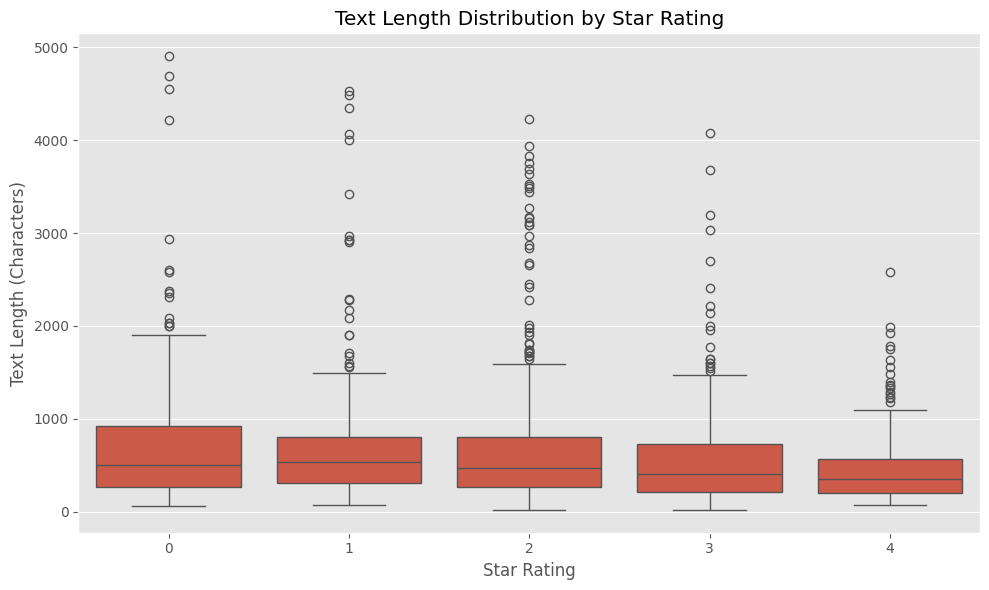

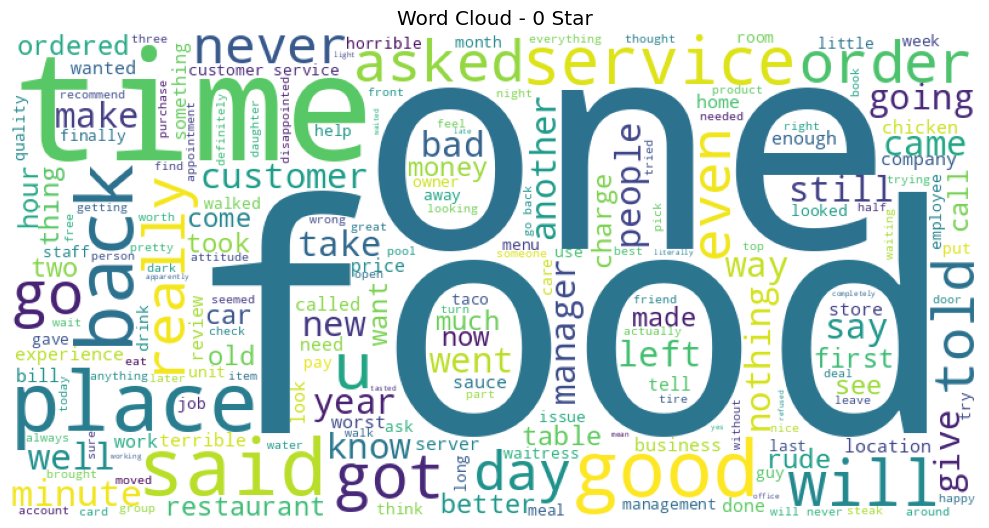

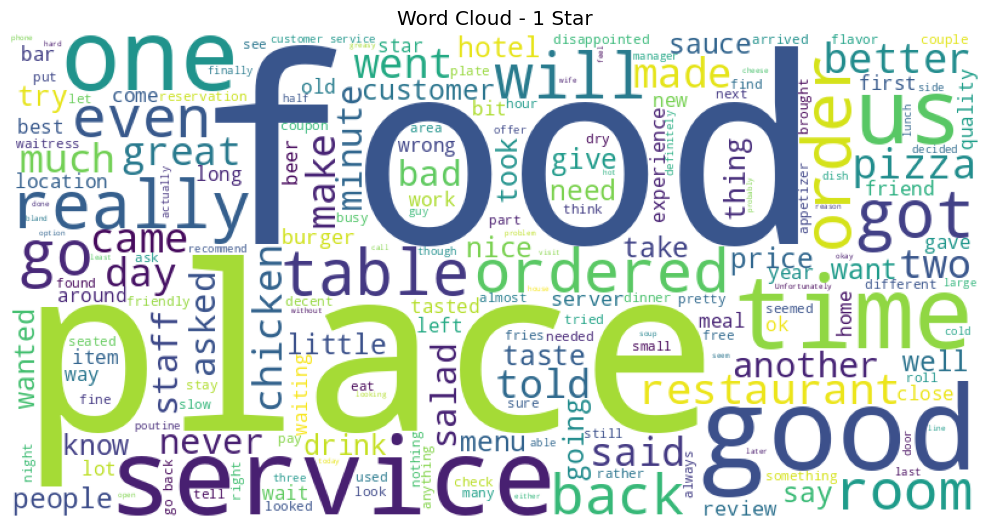

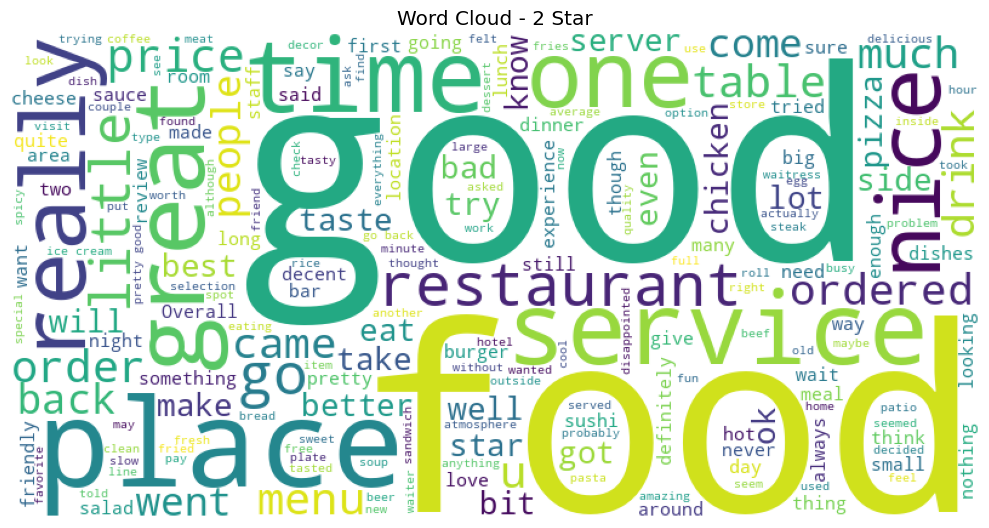

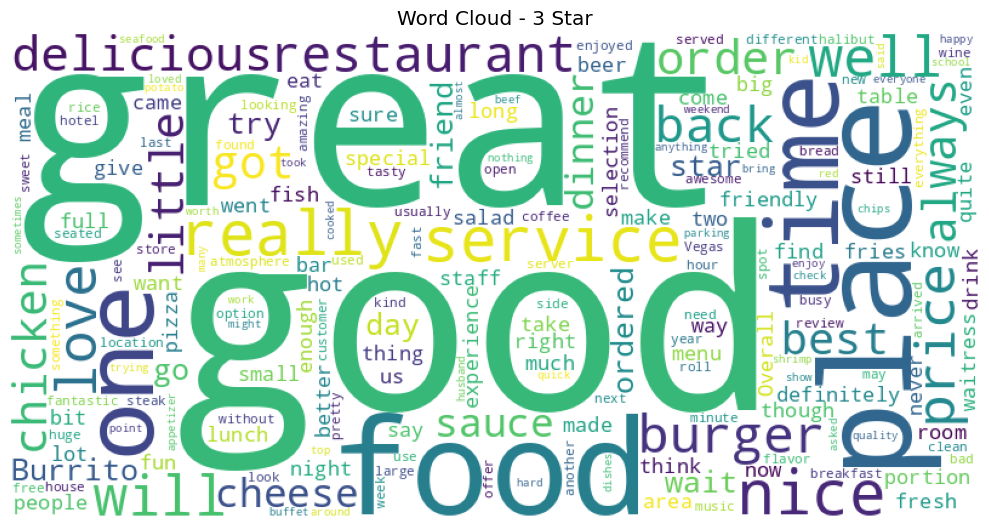

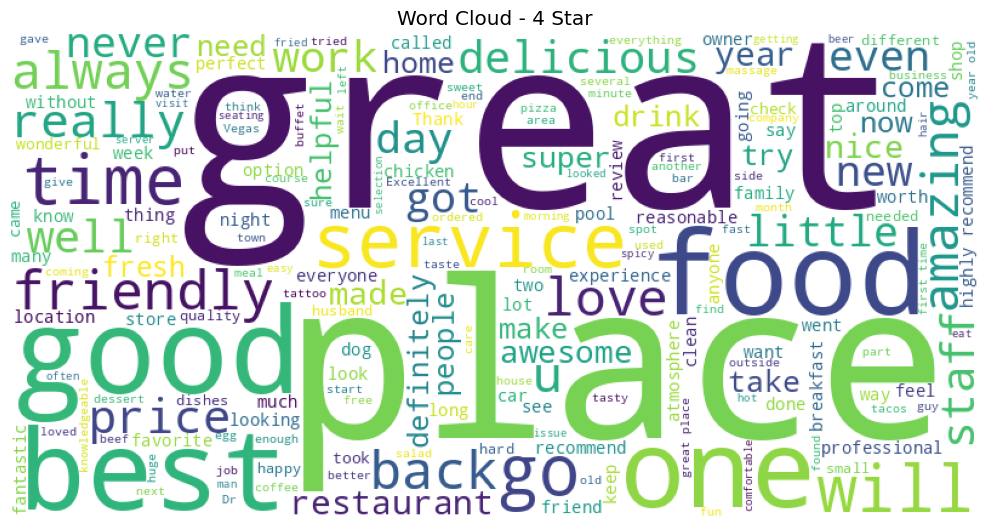

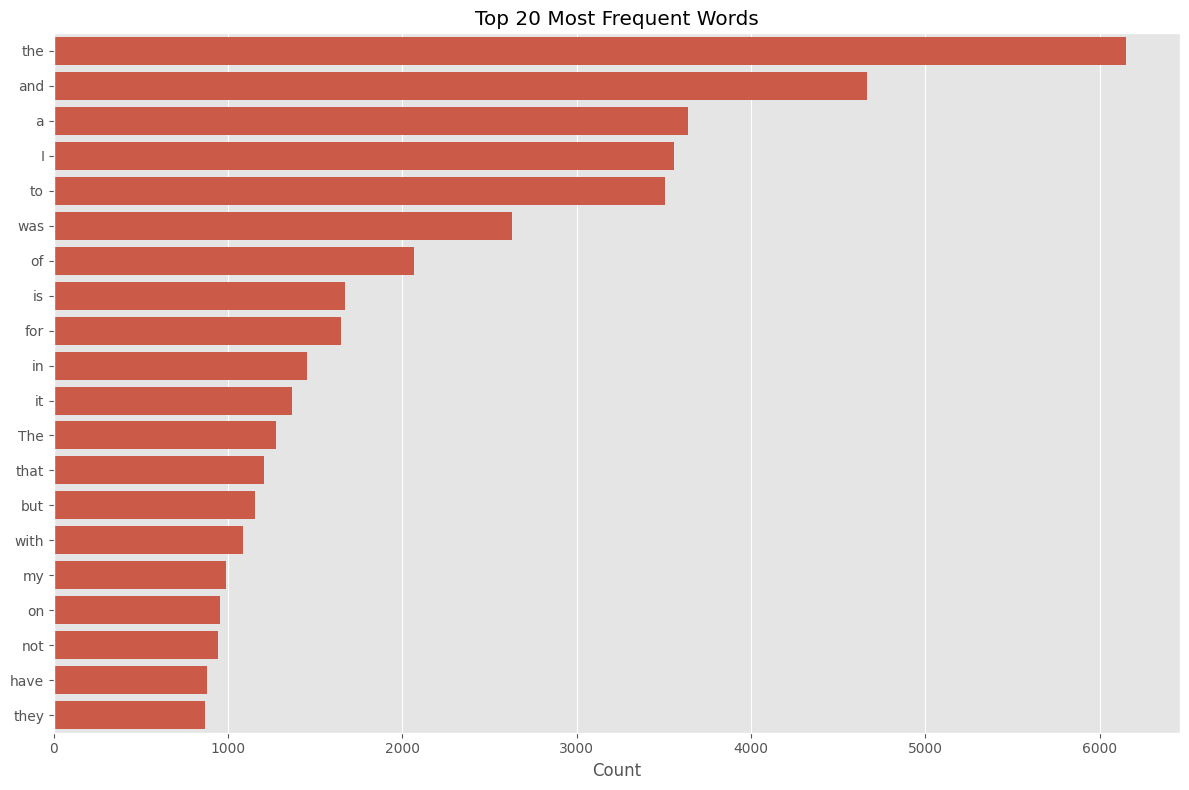

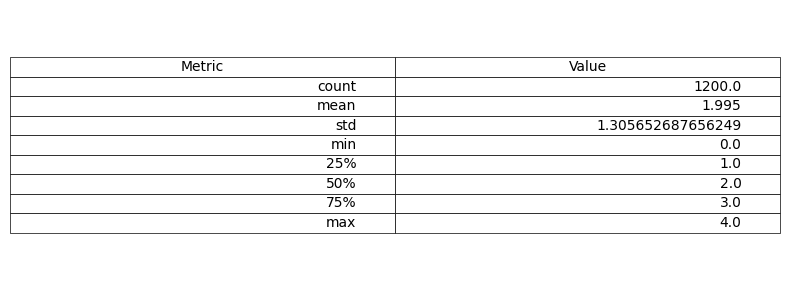

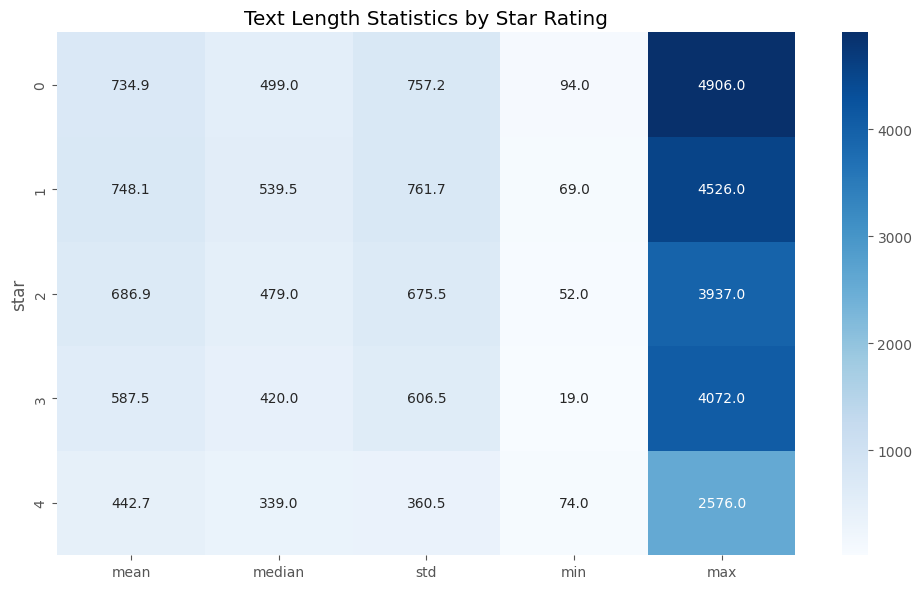

In [32]:
# Convert to pandas DataFrames
train_df = split_dataset["train"].to_pandas()
test_df = split_dataset["test"].to_pandas()

# --- 1. Star Rating Distribution (Train vs Test) ---
plt.figure(figsize=(10, 6))
sns.countplot(x='star', data=train_df, color='skyblue', label='Train', alpha=0.7)
sns.countplot(x='star', data=test_df, color='red', label='Test', alpha=0.7)
plt.title('Star Rating Distribution in Train/Test Sets')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig("star_rating_distribution.pdf", bbox_inches='tight')
plt.show()
plt.close()

# --- 2. Text Length Analysis ---
plt.figure(figsize=(10, 6))
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)
sns.boxplot(x='star', y='text_length', data=pd.concat([train_df, test_df]))
plt.title('Text Length Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Text Length (Characters)')
plt.tight_layout()
plt.savefig("text_length_boxplot.pdf", bbox_inches='tight')
plt.show()
plt.close()

# --- 3. Word Clouds for Each Star Rating ---
unique_stars = sorted(train_df['star'].unique())
for star in unique_stars:
    plt.figure(figsize=(10, 6))
    text = ' '.join(train_df[train_df['star'] == star]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud)
    plt.title(f'Word Cloud - {star} Star')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"wordcloud_{star}_star.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

# --- 4. Top 20 Most Frequent Words ---
plt.figure(figsize=(12, 8))
all_words = ' '.join(train_df['text']).split()
word_freq = Counter(all_words).most_common(20)
sns.barplot(x=[count for word, count in word_freq], 
            y=[word for word, count in word_freq])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig("top_20_words.pdf", bbox_inches='tight')
plt.show()
plt.close()

# --- 5. Statistical Metrics Table ---
plt.figure(figsize=(8, 3))
stats_df = train_df['star'].describe().reset_index()
stats_df.columns = ['Metric', 'Value']
cell_text = [[row[0], row[1]] for row in stats_df.values]
plt.table(cellText=cell_text, colLabels=stats_df.columns, loc='center')
plt.axis('off')
plt.tight_layout()
plt.savefig("statistical_metrics.pdf", bbox_inches='tight')
plt.show()
plt.close()

# --- 6. Text Length Statistics Heatmap ---
plt.figure(figsize=(10, 6))
length_stats = train_df.groupby('star')['text_length'].agg(['mean', 'median', 'std', 'min', 'max'])
sns.heatmap(length_stats, annot=True, fmt=".1f", cmap='Blues')
plt.title('Text Length Statistics by Star Rating')
plt.tight_layout()
plt.savefig("text_length_stats.pdf", bbox_inches='tight')
plt.show()
plt.close() 

In [21]:
# Additional Statistical Analysis
print("\nCentral Tendency:")
print(f"Mean Star Rating: {train_df['star'].mean():.2f}")
print(f"Median Star Rating: {train_df['star'].median()}")
print(f"Mode Star Rating: {train_df['star'].mode()[0]}")

print("\nDispersion Metrics:")
print(f"Range: {train_df['star'].max() - train_df['star'].min()}")
print(f"Variance: {train_df['star'].var():.2f}")
print(f"Standard Deviation: {train_df['star'].std():.2f}")
print("Quartiles:\n" + str(train_df['star'].quantile([0.25, 0.5, 0.75])))

print("\nClass Balance Analysis:")
print("Train Set Distribution:\n" + str(train_df['star'].value_counts(normalize=True)))
print("\nTest Set Distribution:\n" + str(test_df['star'].value_counts(normalize=True)))


Central Tendency:
Mean Star Rating: 2.00
Median Star Rating: 2.0
Mode Star Rating: 2

Dispersion Metrics:
Range: 4
Variance: 1.70
Standard Deviation: 1.31
Quartiles:
0.25    1.0
0.50    2.0
0.75    3.0
Name: star, dtype: float64

Class Balance Analysis:
Train Set Distribution:
star
2    0.334167
0    0.174167
4    0.171667
1    0.160000
3    0.160000
Name: proportion, dtype: float64

Test Set Distribution:
star
2    0.330000
1    0.193333
3    0.193333
4    0.146667
0    0.136667
Name: proportion, dtype: float64


## 5. Explore different methods to improve your baseline models

In section 2&3, we have tried multiple embedding methods and performed hyper-parameter tuning, we found that:
- Using BERT embedding will increase the accuracy of `LogisticRegression` (our baseline model)

So futher directions will be:
- Explore more efficient and effective encoding methods
- Keep Hyper-parameter searching (use Grid Search to perform exhausted parameter searching)

Actual modifications:
- Modify the BERT embedding: we refer to `BERTForSequenceClassification` to take the first token embedding as the pooling function. See `transformers/models/bert/modeling_bert.py` in transformers library for more details.
- Use `Optuna` as the advanced hyper-paramter serach teniques
- Use `PCA` to reduce the redundant features and decrease the computational complexity of the model, thus increasing the searching efficiency
- Ultimately, we think the increase of the performance is largely due to the feature extraction ability of BERT model, because the `BERTForSequenceClassification` includes a BERT feature extractor and a linear classifier named `Classification Head` in context of BERT model

**Final Results:**
- **Original Baseline: 0.4667 Accuracy**
- **Our Tuned Model: 0.5067 Accuracy**

In [22]:
def modified_bert_embedding(train_text, test_text, max_length=128):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",cache_dir="./")
    model = BertModel.from_pretrained("bert-base-uncased",cache_dir="./")
    
    def text_to_embeddings(texts):
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:,0].numpy()
    
    X_train = text_to_embeddings(train_text)
    X_test = text_to_embeddings(test_text)
    return X_train, X_test

In [23]:
X_train, X_test = modified_bert_embedding(train_text, test_text)

Original shape (train): (1200, 768)
Reduced shape (train): (1200, 280)
Original shape (test): (300, 768)
Reduced shape (test): (300, 280)


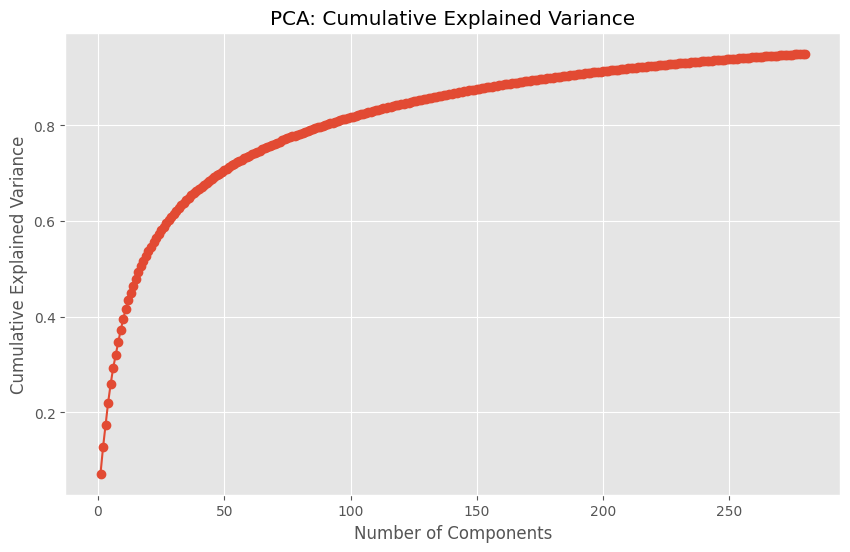

Number of components selected: 280


In [24]:
# 1. Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Apply PCA to reduce dimensionality
# Choose the number of components (e.g., 95% variance)
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Check the new shape
print(f"Original shape (train): {X_train.shape}")
print(f"Reduced shape (train): {X_train_pca.shape}")
print(f"Original shape (test): {X_test.shape}")
print(f"Reduced shape (test): {X_test_pca.shape}")

# 4. Visualize explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

# 5. Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

In [ ]:
# will take about 0.5 hour using AMD5995WX 64 core cpu.
X_train=X_train_pca
X_test=X_test_pca

def objective(trial):
    # Define hyperparameter search space
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'solver': trial.suggest_categorical('solver', ['saga', 'liblinear']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1) if 
                    trial.params['penalty'] == 'elasticnet' else None
    }
    
    # Handle parameter dependencies
    if params['penalty'] == 'elasticnet':
        params['solver'] = 'saga'
    
    # Create and validate model
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    
    return np.mean(scores)

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10000, timeout=3600,n_jobs=80,show_progress_bar=True)

# Show best parameters
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"{key:15} → {value}")

[I 2025-04-01 16:31:23,974] A new study created in memory with name: no-name-9e5d31b7-d9ee-4eef-8747-2387b017154b


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-01 16:31:24,105] Trial 5 finished with value: 0.45083333333333336 and parameters: {'penalty': 'l1', 'C': 0.005167976414966427, 'solver': 'liblinear', 'class_weight': None, 'max_iter': 562}. Best is trial 5 with value: 0.45083333333333336.
[I 2025-04-01 16:31:24,140] Trial 11 finished with value: 0.4808333333333333 and parameters: {'penalty': 'l1', 'C': 0.025002823720624245, 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 550}. Best is trial 11 with value: 0.4808333333333333.
[I 2025-04-01 16:31:24,249] Trial 4 finished with value: 0.4708333333333334 and parameters: {'penalty': 'l1', 'C': 0.20962822852315707, 'solver': 'liblinear', 'class_weight': None, 'max_iter': 939}. Best is trial 11 with value: 0.4808333333333333.
[I 2025-04-01 16:31:24,311] Trial 25 finished with value: 0.45916666666666667 and parameters: {'penalty': 'l2', 'C': 0.00010903745397845421, 'solver': 'liblinear', 'class_weight': None, 'max_iter': 174}. Best is trial 11 with value: 0.48083333333

In [30]:
best_params = study.best_params.copy()
if best_params['penalty'] == 'elasticnet':
    best_params['solver'] = 'saga'
# Train final model with best parameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

# Evaluate
test_pred = best_model.predict(X_test)
print("\nFinal Evaluation:")
print(classification_report(y_test, test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")

# Visualization
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


Final Evaluation:
              precision    recall  f1-score   support

           0       0.49      0.80      0.61        41
           1       0.46      0.10      0.17        58
           2       0.50      0.77      0.60        99
           3       0.44      0.14      0.21        58
           4       0.59      0.66      0.62        44

    accuracy                           0.51       300
   macro avg       0.50      0.49      0.44       300
weighted avg       0.49      0.51      0.45       300

Test Accuracy: 0.5067
